## NAME: Manuel Arnau Fernández

## NIU: 1597487

## Introduction

The Chinese MNIST is a dataset built to practice with image classification models. Similar to MNIST, each image is a handwritten number in greyscale, but in this case the chinese characters are used. Therefore, the objective is to label with the correct number given the image, thus is an ideal dataset to use CNN.

#### References

The material and references used in order to work with this dataset are the following:

https://www.kaggle.com/code/stpeteishii/chinese-mnist-classify-torch-linear/notebook

https://pypi.org/project/albumentations/

https://albumentations.ai/docs/examples/pytorch_classification/#Set-the-root-directory-for-the-downloaded-dataset

https://www.datacamp.com/tutorial/complete-guide-data-augmentation

https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md

https://www.kaggle.com/code/enwei26/mnist-digits-pytorch-cnn-99/notebook

https://www.kaggle.com/code/pritishmishra/augmentation-with-albumentations

https://www.kaggle.com/code/chekoduadarsh/starters-guide-convolutional-xgboost/notebook

https://www.kaggle.com/code/gpreda/chinese-mnist-exploratory-data-analysis

https://github.com/Tigeryang93/cnn-with-xgboost

https://pythonguides.com/pytorch-early-stopping/

https://scikit-learn.org/stable/modules/grid_search.html

https://stackoverflow.com/questions/54413160/training-validation-testing-batch-size-ratio

https://www.python-engineer.com/courses/pytorchbeginner/10-dataset-transforms/

https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau

https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

#### Packages for the analysis

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Checking what do we have at the current directory and setting the path for images

In [2]:
os.listdir("./chinese-mnist")
IMAGE_PATH = "./chinese-mnist/data/data/"

#### Loading the dataset

In [3]:
dataset_raw = pd.read_csv("./chinese-mnist/chinese_mnist.csv")

We have 15000 samples that each contains 5 features

In [4]:
dataset_raw.shape

(15000, 5)

Let's see how does the dataset look

In [5]:
dataset_raw.sample(5).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 8961 to 11906
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   suite_id   5 non-null      int64 
 1   sample_id  5 non-null      int64 
 2   code       5 non-null      int64 
 3   value      5 non-null      int64 
 4   character  5 non-null      object
dtypes: int64(4), object(1)
memory usage: 240.0+ bytes


#### Data description

suite_id: ID of the person that wrote the number. (int)

sample_id: Nº of sample wrote by the person (total of 10 for each number). (int)

code: Code that identifies each of the 15 numbers, ranging from 1 to 15. (int)

value: Actual value of the written number. (int)

character: the Chinese character. (object)

The target will be code, since it gives a numerical identifier to each class. We do not use character since it is a categorical variable, and we would have to do encoding.

The images follow this pattern: "input_{suiteid}{sampleid}{code}.jpg". This will be useful later.

### Data Exploration and Analysis

#### Cleaning dataset

First of all we have to check if the dataset contain NaN values in any columns. To do so, we create a function that return a table with the total of NaNs for column and the percentage that represents.

In [6]:
def checking_nans(dataset):
    total = dataset.isnull().sum()
    percent = total/dataset.count()
    return pd.concat([total,percent], axis=1, keys=['Total','Percentage'])

In [7]:
checking_nans(dataset_raw)

,Total,Percentage
suite_id,0,0.0
sample_id,0,0.0
code,0,0.0
value,0,0.0
character,0,0.0


There are no NaN values, so we can proceed without doing any modification in this case.

The next step is to check if it is correctly labeled. In other words, to see if any of the images is labeled with a number that does not correspond to the information of said image in the dataset. 

We will check how many groups of three of code, value and character do exist

In [8]:
#To check if there is wrong labelling
dataset_unique = dataset_raw.drop(["suite_id", "sample_id"], 'columns')

In [9]:
def checking_wrong_labelling(dataset):
    return pd.DataFrame(dataset.value_counts())
    

In [10]:
checking_wrong_labelling(dataset_unique)

,,,0
code,value,character,
1,0,零,1000
2,1,一,1000
3,2,二,1000
4,3,三,1000
5,4,四,1000
6,5,五,1000
7,6,六,1000
8,7,七,1000
9,8,八,1000


There is no mislabelling, and we can see which value does each code representents and its chinese character.

There might be missmatching between the labelling of the dataframes and the images, but if there is, we will find it out during the testing phase looking at the wrong predictions.

#### Studying distributions

Looking at the values of the last table, we expect to have the same number of samples for each value in each colums. Nonethells, we  will check this doing some graphs of the distributions.

In [11]:
print(f"Number of suites: {dataset_raw.suite_id.nunique()}")
print(f"Samples: {dataset_raw.sample_id.nunique()}: {list(dataset_raw.sample_id.unique())}")


Number of suites: 100
Samples: 10: [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]


<AxesSubplot:xlabel='suite_id', ylabel='count'>

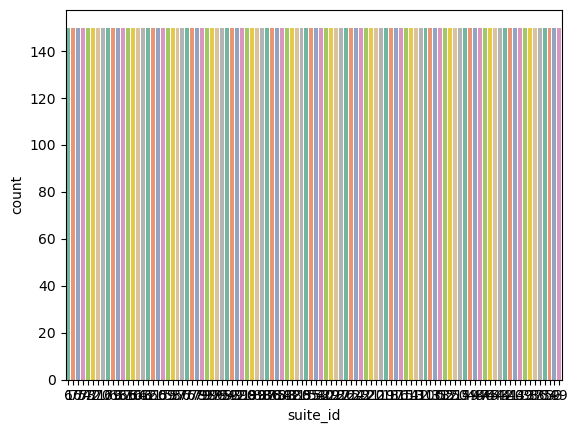

In [12]:
sns.countplot(dataset_raw["suite_id"], order = dataset_raw["suite_id"].value_counts().index[:], palette='Set2')

In [13]:
def plot_distribution(dataset,feature):
    f, ax = plt.subplots(1,1, figsize=(16,4))
    total = float(len(dataset))
    g = sns.countplot(dataset[feature], order = dataset_raw[feature].value_counts().index[:], palette='Set2')
    g.set_title("Number of {}".format(feature))
    plt.show()  

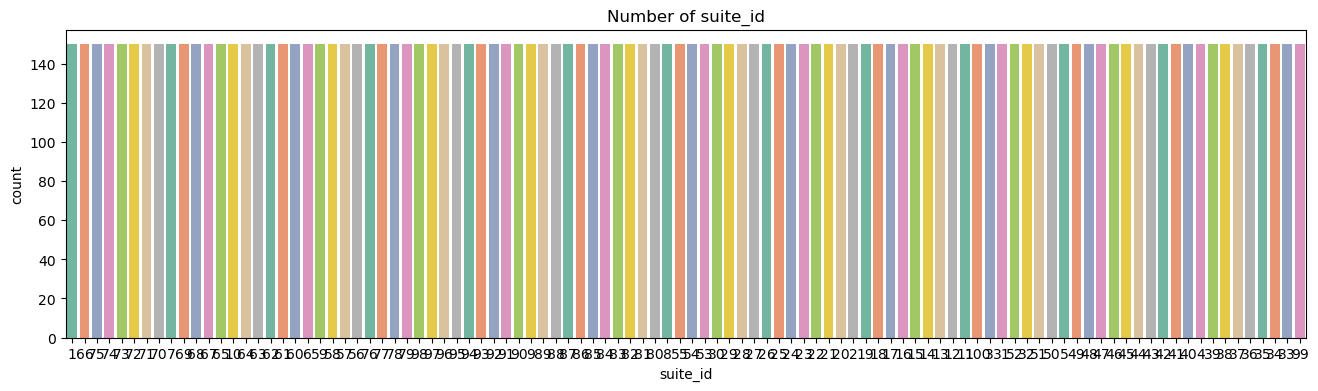

In [14]:
plot_distribution(dataset_raw,"suite_id")

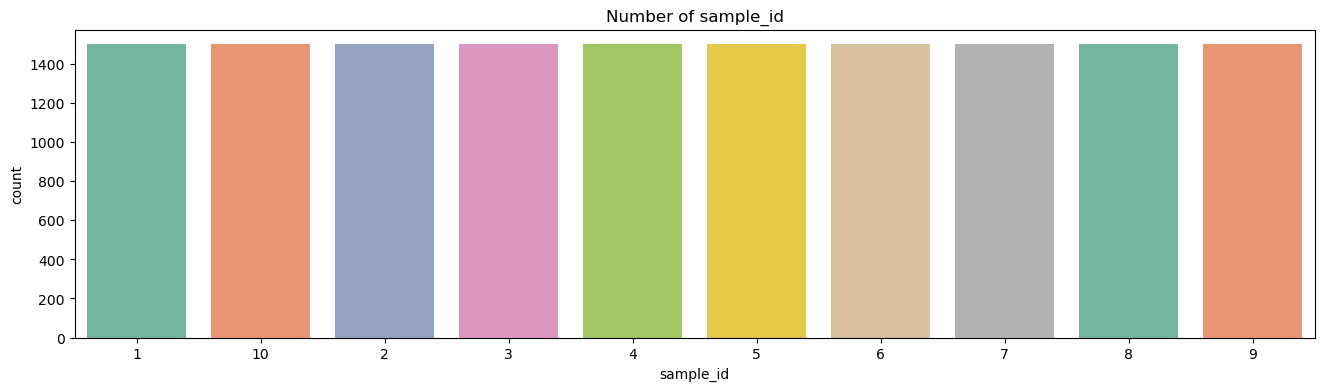

In [15]:
plot_distribution(dataset_raw,"sample_id")

As expected, in each of the graphics the values of the y-axis are the same, as we expected given that each participant handwrote the same amount of numbers for all the values in the dataset

#### Image exploration

In [16]:
image_files = list(os.listdir("./chinese-mnist/data/data"))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 15000


Lets check if all images have the same size. We will use the skimage library. The following function return the image sizes, to make sure that all images are same size

In [17]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return (image.shape)

In [18]:
sizes = map(read_image_sizes,image_files)
print(set(sizes)) #The set return unique tuples


{(64, 64)}


All images are 64x64, so we won't need to resize any image. Let's add to the dataset a column giving information of the width and the height of each photo, just in case.

In [19]:
dataset_with_images = dataset_raw
dataset_with_images['w']=64
dataset_with_images['h']=64

Now we need to add to each row the corresponding image using the pattern specified earlier. To do so we create a function, and we apply it to the dataset.

In [20]:
def create_file_name(x):
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg" 
    return file_name

In [21]:
dataset_with_images["file_name"] = dataset_with_images.apply(create_file_name, axis=1)
dataset_with_images.head()

,suite_id,sample_id,code,value,character,w,h,file_name
0,1,1,10,9,九,64,64,input_1_1_10.jpg
1,1,10,10,9,九,64,64,input_1_10_10.jpg
2,1,2,10,9,九,64,64,input_1_2_10.jpg
3,1,3,10,9,九,64,64,input_1_3_10.jpg
4,1,4,10,9,九,64,64,input_1_4_10.jpg


We save the new data set, so we can upload it without going through all the process again

In [22]:
filepath = Path('./chinese-mnist/chinese_mnist_images.csv')  
dataset_with_images.to_csv(filepath) 
#We save the new dataset

Let's plot 20 random images to see how they look

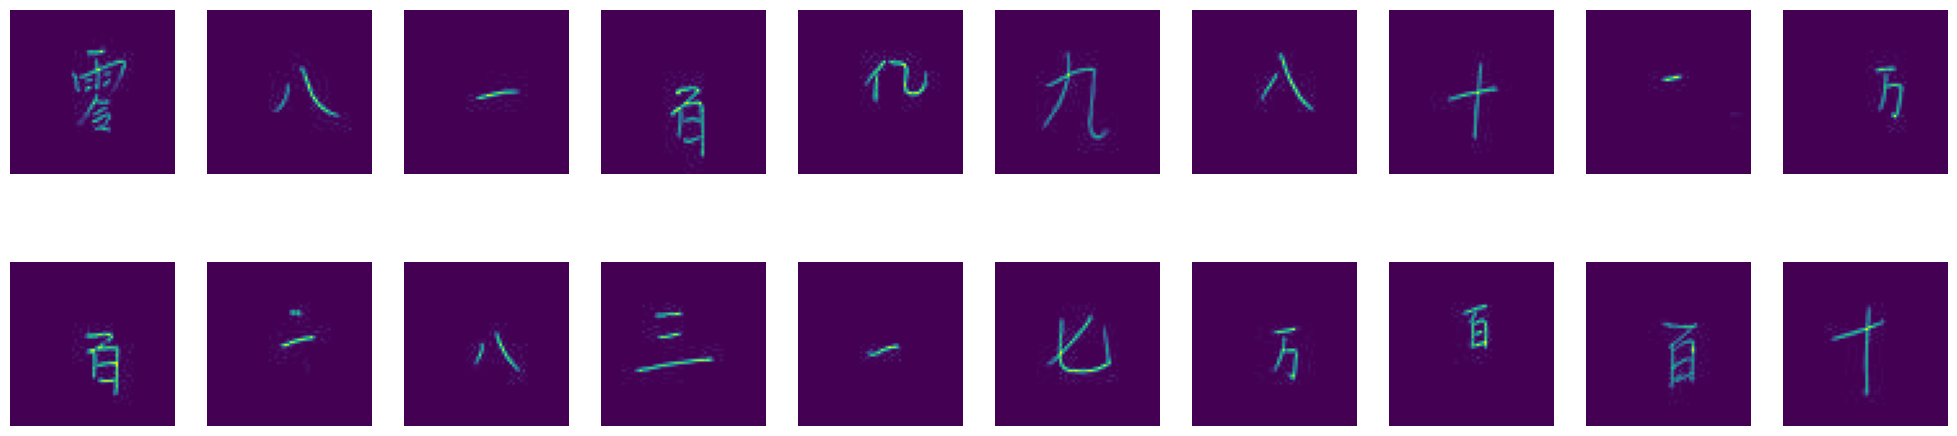

In [23]:
f, ax = plt.subplots(2,10, figsize=(25,6))
index = np.random.randint(15000, size=20) #20 random indexes to plot from

for i,num in enumerate(index):
    img_data = skimage.io.imread(IMAGE_PATH + image_files[num])
    ax[i//10, i%10].imshow(img_data)
    ax[i//10, i%10].axis('off')
plt.show()

Finally, we need to set up the dataset in order to be suitable for classification. Given that we only are going to use the images to train them, we can create an array that each position contains one image, and a target array that has the code associated to.

In [24]:
images = []
for i in dataset_with_images['file_name']:
    a = skimage.io.imread(IMAGE_PATH + i)
    images.append(a)
target = dataset_with_images['code']
images = np.array(images)



Now we have a list with all the images, and another list with all the targets (code), so we can proceed with fitting models.

## Machine Learning models

The dataset fits perfectly to use CNN, and we will create such a model, but before we will try to do KNN (supervised model), a RandomForestClassifier (bagging ensamble method) and XGBoost (boosting ensamble method). 
Firstly we will only use accuracy to discriminate between the models and see if they are worth more training and more study or not, and then search for the best hyperparameters

#### Packages for modelling

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import time

We split the train and test data. Since we have the same amount of data for each class, it is important to keep the proportionality during the training and testing, so we are sure that if a class underperforms it is not because there was not enough data for the training. We do a KFolds cross-validation to avoid overfitting and be able to see which models are better.
For all this models we need to flatten our images and standarize.

Note: During the stratification, it only takes into account the code, so there might be handwritting from someone that does not appear. While this most likely will decrease the accuracy, it is of our interest to see if the model can classify correctly the number of a handwrittin never seen before

In [137]:
flat_images = images.reshape(15000,4096)

sc = StandardScaler()
X_std = sc.fit_transform(flat_images)


CV_Splits = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
n_splits = 5
train_idx = []
test_idx = []
for i, (train_index, test_index) in enumerate(CV_Splits.split(flat_images, target)):
    train_idx.append(train_index)
    test_idx.append(test_index)

We define a train and test function suitable for all models.

In [138]:
def train(method,params,X,y):
    model = method(**params)
    model.fit(X,y)
    return model

In [139]:
def test(model, X, y):
    return model.score(X,y)

#### KNN

In [352]:
acc_test = []
acc_train = []
params = {'n_neighbors':2}

t1 = time.time()

for tr_idx,te_idx in zip(train_idx, test_idx):
    KNN = train(KNeighborsClassifier,params,flat_images[tr_idx],target[tr_idx])
    acc_train.append(test(KNN,flat_images[tr_idx],target[tr_idx]))
    acc_test.append(test(KNN,flat_images[te_idx],target[te_idx]))

print(acc_train)
print(acc_test)
print("Temps transcurrit:",time.time()-t1)

[0.6513333333333333, 0.6510833333333333, 0.65125, 0.6466666666666666, 0.6518333333333334]
[0.4136666666666667, 0.4056666666666667, 0.41533333333333333, 0.4093333333333333, 0.4146666666666667]
Temps transcurrit: 337.9129738807678


The model does not perform really well, and it is quite computationally expensive

#### Random Forest Classifier

In [353]:
acc_test = []
acc_train = []
params = { 'n_estimators': 50,
          'max_depth': 15}

t1 = time.time()

for tr_idx,te_idx in zip(train_idx, test_idx):
    RFC=train(RandomForestClassifier,params,flat_images[tr_idx],target[tr_idx])
    acc_train.append(test(RFC,flat_images[tr_idx],target[tr_idx]))
    acc_test.append(test(RFC,flat_images[te_idx],target[te_idx]))

print(acc_train)
print(acc_test)

print("Temps transcurrit:",time.time()-t1)

[0.9420833333333334, 0.9456666666666667, 0.9424166666666667, 0.943, 0.9370833333333334]
[0.5643333333333334, 0.5526666666666666, 0.5436666666666666, 0.5686666666666667, 0.558]
Temps transcurrit: 44.9534547328949


It performs better than the KNN, although we can see there is some overfitting. Given that is a Random Forest, it does not bother us the overfitting.

#### XGBoost

In [354]:
acc_test = []
acc_train = []
params = {'n_estimators':3,
        'objective': 'multi:softmax'}

t1 = time.time()

for tr_idx,te_idx in zip(train_idx, test_idx):
    XGBC = train(XGBClassifier,params,flat_images[tr_idx],target[tr_idx]-1)
    acc_test.append(test(XGBC,flat_images[te_idx],target[te_idx]-1))
    acc_train.append(test(XGBC,flat_images[tr_idx],target[tr_idx]-1))

print(acc_train)
print(acc_test)
print("Temps transcurrit:",time.time()-t1)


[0.6525, 0.6505833333333333, 0.6546666666666666, 0.64625, 0.6486666666666666]
[0.44433333333333336, 0.4246666666666667, 0.42, 0.43, 0.436]
Temps transcurrit: 573.5872781276703


It has results similar to KNN models, low accuracy and high time elapsed. We would need more estimators to achieve better results, since the more trees the better results should get.

The table to compare all the results is the following. 

| Model | Mean Train Accuracy (%) | Mean Test Accuracy (%) | Time Elapsed (s) |
| ----------------|---------------|-----------------|-----------------|
| KNN | 65 | 41 | 338 |
| RandomForestClassifier | 94 | 55 | 45 |
| XGBoost | 65 | 43 | 573 |

Random Forest is clearly the best out of the three.

### Hyperparameter Search

CrossValidation helps use to avoid any overfitting, and also to see which models perfom better. It is also used for Hyperparameter Search, the next step to improve our models (those are for testing, the one that will give us good results is the CNN). Seeing that KNN and XGBoost take quite a time with parameters set at very low values, we will only perfom Hyperparameter Tunning with RandomForest, the model that has given us the best result yet.
We will search for the optimal parameters with successive halving, given that a complete grid search could take quite long with the cpu that is being used.

In [140]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

base_estimator = RandomForestClassifier(random_state=0)
param_grid = {'max_depth': [25, 50, None],
                'min_samples_split': [10, 20],
                 'criterion': ["gini"],
                 'n_estimators': [25, 200]}

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=4,
                    factor=2, min_resources = 'exhaust',
                         aggressive_elimination=True,n_jobs=-1).fit(flat_images, target)

sh.best_estimator_

RandomForestClassifier(max_depth=50, min_samples_split=10, n_estimators=200,
                       random_state=0)

Those are the best combination of parameters out of all the possibles. Below it's the dataset with the result of all the combinations, and it also tells us at which iteration each combination faded.

In [141]:
pd.DataFrame(sh.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0,1875,4.092575,0.072989,0.199141,0.058325,gini,25,10,25,...,0.335470,0.383547,0.041115,20,0.989331,0.987909,0.987909,0.988620,0.988442,0.000590
1,0,1875,19.483988,0.188707,0.541813,0.040045,gini,25,10,200,...,0.442308,0.487179,0.052882,14,0.997866,1.000000,0.997866,0.999289,0.998755,0.000924
2,0,1875,2.084248,0.054692,0.102766,0.027284,gini,25,20,25,...,0.331197,0.368590,0.032912,21,0.922475,0.930299,0.934566,0.937411,0.931188,0.005631
3,0,1875,19.842775,0.598885,0.722919,0.242674,gini,25,20,200,...,0.405983,0.454060,0.055934,17,0.975818,0.987198,0.978663,0.977952,0.979908,0.004337
4,0,1875,2.727527,0.023219,0.093129,0.012526,gini,50,10,25,...,0.348291,0.387821,0.037271,18,0.989331,0.990754,0.991465,0.990043,0.990398,0.000795
5,0,1875,18.354759,0.044347,0.405909,0.017279,gini,50,10,200,...,0.440171,0.491453,0.051282,12,0.998578,1.000000,0.998578,0.999289,0.999111,0.000590
6,0,1875,1.787483,0.051236,0.070591,0.015776,gini,50,20,25,...,0.335470,0.367521,0.034751,22,0.928876,0.930299,0.938834,0.931721,0.932432,0.003830
7,0,1875,13.519097,0.181150,0.378959,0.032157,gini,50,20,200,...,0.416667,0.462073,0.047955,15,0.975107,0.987198,0.980085,0.980085,0.980619,0.004308
8,0,1875,2.716247,0.496764,0.145003,0.108576,gini,None,10,25,...,0.348291,0.387821,0.037271,18,0.989331,0.990754,0.991465,0.990043,0.990398,0.000795
9,0,1875,20.761002,0.860900,1.192438,0.234302,gini,None,10,200,...,0.440171,0.491453,0.051282,12,0.998578,1.000000,0.998578,0.999289,0.999111,0.000590


In [ ]:
| Model | Mean Train Accuracy (%) | Mean Test Accuracy (%) | Time Elapsed (s) |
| ----------------|---------------|-----------------|-----------------|
| KNN | 65 | 41 | 338 |
| RandomForestClassifier | 94 | 55 | 45 |
| XGBoost | 65 | 43 | 573 |

Let's check what result do we achieve with a normal train and test split (stratified) with the best parameters found.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(flat_images, target, test_size=0.3, random_state=0,stratify=target)

params = {'n_estimators':200, 'criterion':'gini','max_depth':50,
         'min_samples_split':10, 'random_state':0}
t1 = time.time()
RFC = train(RandomForestClassifier,params,X_train,y_train)
print(test(RFC,X_train,y_train))
print(test(RFC,X_test,y_test))
print("Temps transcurrit:",time.time()-t1)



0.9986666666666667
0.6351111111111111
Temps transcurrit: 183.58114504814148


There is clearly overfitting, but the accuracy achieved is quite decent, and given the nature of the dataset and how Random Forest works, we can ignore it a bit.

### Metric Analysis

We have achieved a decent result for accuracy given that it is not the most suitable model for image classification. Nonetheless, accuracy is just one of the possible metrics, and it is of our interest to see how the model performs with other metrics.
We will perform a confusion matrix, a Precision-Reecall graph and also evaluate the f1-score compared to other metrics of the model on the test. 

We can not compute a general confusion matrix using cross-validation, we can only compute the partials. Therefore, we will not use cross-validation to proceed with the metric analysis, to avoid saturation of graphics.

First, let's have a look again on the corresponding character for each code

In [143]:
pd.DataFrame(dataset_unique.value_counts())

,,,0
code,value,character,
1,0,零,1000
2,1,一,1000
3,2,二,1000
4,3,三,1000
5,4,四,1000
6,5,五,1000
7,6,六,1000
8,7,七,1000
9,8,八,1000


#### Confusion Matrix

First of all let's see how the confusio matrix of our predictions made by our RandomForest model is

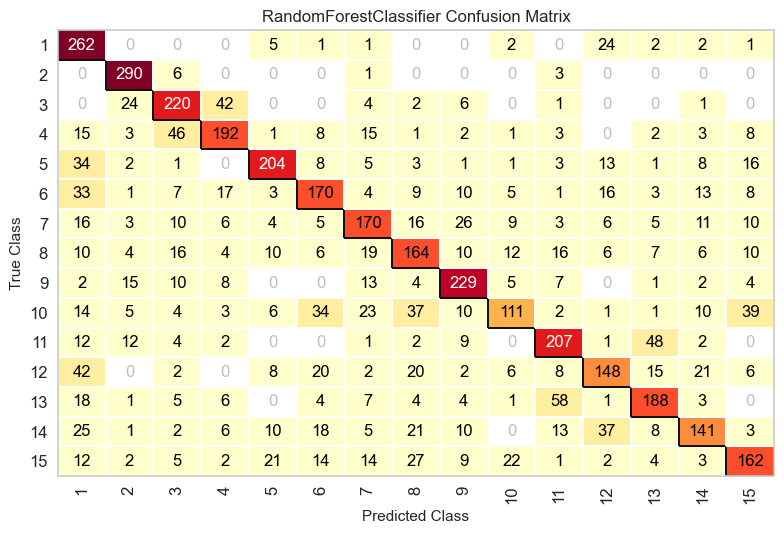

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [144]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(RFC)

cm.score(X_test, y_test)

cm.show()

We clearly see that the performance is not the same for all classes. If we check how the characters of the better predicted classes are, we can conclude that less complex characters or overly complicated characters (the one corresponding to code 1) are easier to predict for our model, which makes sense since our madel can't grasp all the details of the image, but can generalize it.

Next, we will perform a Precision-Recall curve and compute the Area Under the Curve, to see how each class performs with this metric (good classes will be closer to the top right, bad classes to the bottom left)

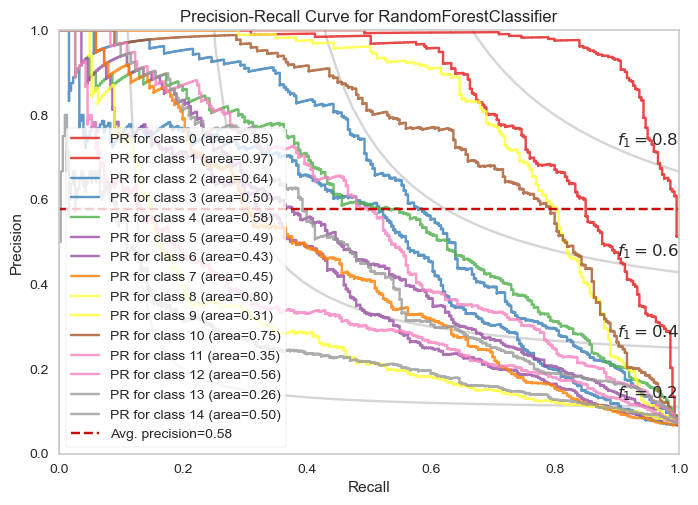

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [147]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    RandomForestClassifier(**params),
    iso_f1_curves=True,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()


We can see the correlation between the confusion matrix and the Precision-Recall Curve, those characters with higher values in the diagonal have also a higher AUC, and vice-versa, and are closer to the top right. (Note that the index starts with 0 in the graph). The graph is a bit messys since there are many classes, but the main output from it is that the model does not perform well for most of the classes.

Finally, let's compare all metrics using classification_report from sklearn (basically see the graph represented numerically)

In [145]:
pred = RFC.predict(X_test)
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.53      0.87      0.66       300
           2       0.80      0.97      0.87       300
           3       0.65      0.73      0.69       300
           4       0.67      0.64      0.65       300
           5       0.75      0.68      0.71       300
           6       0.59      0.57      0.58       300
           7       0.60      0.57      0.58       300
           8       0.53      0.55      0.54       300
           9       0.70      0.76      0.73       300
          10       0.63      0.37      0.47       300
          11       0.63      0.69      0.66       300
          12       0.58      0.49      0.53       300
          13       0.66      0.63      0.64       300
          14       0.62      0.47      0.54       300
          15       0.61      0.54      0.57       300

    accuracy                           0.64      4500
   macro avg       0.64      0.64      0.63      4500
weighted avg       0.64   

From this table, jointly with the confussion matrix and the plot, we can see that the accuracy is unbalanced between classes, mainly if we focus on recall, there are few classes that perfrom really poorly there. From this we can extract that the model is not complex enough to extract the information to classify those classes, and end up classified wrongly.

Traditional Machine Learning models are not sufficient for such complex datasets (each sample contains 4096 data points, each pixel on the iamge) and, for example for a Random Forest, to perform well it would cost a lot computationally (lots of estimators/trees, not setting maximum depth and setting minimum sample for split 1, to have a leaf for each pixel). That's why we are going to use a CNN model to fit our data, a Deep Learning model built with the purpose to classify images. We are using PyTorch to build the model (we could also use TensorFlow , Keras, ...)

## Deep Learning Models (PyTorch)

As mentioned before, Convolutional Neural Networks are fitted for image recognition and classification, and that is because Artificial Neural Networks (the most basic Deep Learning model) can explain more complex models thanks to its architecture.

#### Packages for modelling

In [26]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision import transforms, utils

#### Setting Parameters

We set the parameters for our training and testing. We also set our device (if we had cuda it would we much more quicker).

In [27]:
epochs = 30
batch_size = 100        # number of samples during training
test_batch_size = 1500  # number of samples for test 
seed = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}




#### Setting up the Dataset

We will use the same exact splits used before, to keep consistency and be able to make comparisons. We need to compute the mean and the standard deviation to normalize and also transform to tensor our images (currently arrays). We also have to define the dataset using Dataset module of PyTorch, that facilitates transforming the data.

In [28]:

# We make sure the data is stratified
X_train_idx, X_test_idx, y_train, y_test = train_test_split(list(range(0,15000)), target, test_size=0.3, random_state=0,stratify=target)
target_train = target[X_train_idx]
target_test = target[X_test_idx]
images_train = images[np.array(X_train_idx)]
images_test = images[np.array(X_test_idx)]



In [29]:
#We only compute them from the train set, and we will apply the same transformation 
#to the test images since technically we do not nothing from the test set. 
train_mean = np.mean(images_train)/255. #Mean of all images
train_std = np.std(images_train)/255. #Standard deviation of all images

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((train_mean,), (train_std,))
])


In [30]:
class CustomImageDataset(Dataset):
    def __init__(self, x,y, transform=None):
        self.x = x
        self.img_labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.img_labels.iloc[idx]
        if (self.transform!=None):
            image = self.transform(image)
        return image, label-1

DataLoader makes the dataser iterable, necessary to train the neural network 

In [31]:
train_ds = CustomImageDataset(images_train, target_train, transform)
train_dataloader = torch.utils.data.DataLoader(train_ds, **train_kwargs)

test_ds = CustomImageDataset(images_test, target_test, transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, **test_kwargs)


### CNN Model

The model proposed is a CNN model with seven hidden layers, 3 of them convulational layers where we perform Batch Normalization and a Max Pooling, and 3 fully-connected layers. We use LogSoftMax as the activaction function for the output since we are performing multiclass prediction. We also added a Dropout to regularize and avoid overfitting.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=1200)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=1200, out_features=150)
        self.fc3 = nn.Linear(in_features=150, out_features=15)



    def forward(self, x):
        x = x.unsqueeze(1) #We want only 1 channel as input
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        output = F.log_softmax(out, dim=1)

        return output


#### Train and Test Functions

In [33]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    t = tqdm(enumerate(train_loader), total=len(train_loader))
    t.set_description('Train')
    for batch_idx, (data, target) in t:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() #backpropagation
        data = data.resize_(data.size()[0], 64,64).float()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        t.set_postfix(loss=loss.item())

    return np.mean(losses)

In [34]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    totals = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        t = tqdm(test_loader, total=len(test_loader))
        t.set_description('Test ')
        for data, target in t:
            data, target = data.to(device), target.to(device)
            data = data.resize_(data.size()[0], 64,64).float()
            output = model(data)
            test_loss += criterion(output, target).item() * data.shape[0]  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            totals += len(target)
            t.set_postfix(loss=test_loss/totals, accuracy=100.*correct/totals)
            all_preds.extend(np.asarray(pred))
            all_targets.extend(np.asarray(target))

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy, all_preds, all_targets

#### Auxiliary Functions

Function that performs all the training and testing epochs, displaying on screen the batch that is working on and the resulting loss. For each epoch of the test it shows the accuracy.

When finished all the iterations, it displays a plot with the training loss and the test loss.

In [35]:
def experiment(model, device, loss, optimizer,scheduler, train_loader, test_loader):
    init_time = time.time()
    losses_train = []
    losses_test = []
    accuracies_test = []    
    model.to(device)
    
    for epoch in range(1, epochs + 1):
        print ("EPOCH {}".format(epoch))
        sys.stdout.flush()
        loss_train_epoch = train(model, device, train_loader, optimizer, loss)
        loss_test_epoch, accuracy_epoch, pred, targets = test(model, device, test_loader, loss)

        losses_train.append(loss_train_epoch)
        losses_test.append(loss_test_epoch)
        accuracies_test.append(accuracy_epoch)
        scheduler.step(np.mean(loss_train_epoch))

    plt.plot(range(len(losses_train)), 
             losses_train, label="Training Loss")

    plt.plot(range(len(losses_test)), 
             losses_test, label="Test Loss")
    plt.legend()
    plt.show()
    
    elapsed = time.time()-init_time


    print ("ELAPSED TIME: {:.1f}s".format(elapsed))
    
    return losses_train, losses_test, accuracies_test, elapsed, pred

A complementary function that shows us the number of parameters and the FLOPs of the model

In [36]:
def calculate_parameters_and_flops(current_model):
    from thop import profile
    test_input = torch.randn( 1, 64, 64)
    macs, params = profile(current_model, inputs=(test_input,))  # multiply accumulate operation (GFLOPS = 2 * GMACS)
    # normalment, en gpus i exemples reals, es parlaria minim de Gigaflops.
    # print("%s | %.2f Params(M) | %.3f FLOPs(G)" % (current_model._get_name(), params / (1000 ** 2), macs / (1000 ** 3)))
    print("%s | %.2f Params(M) | %.3f FLOPs(M)" % (current_model._get_name(), params / (1000 ** 2), macs / (1000 ** 2)))
    return macs, params

### Model instantation

EPOCH 1


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.2982, Accuracy: 4025/4500 (89.44%)

EPOCH 2


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1717, Accuracy: 4236/4500 (94.13%)

EPOCH 3


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.2365, Accuracy: 4147/4500 (92.16%)

EPOCH 4


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1931, Accuracy: 4236/4500 (94.13%)

EPOCH 5


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 4390/4500 (97.56%)

EPOCH 6


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 4400/4500 (97.78%)

EPOCH 7


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1173, Accuracy: 4352/4500 (96.71%)

EPOCH 8


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1591, Accuracy: 4264/4500 (94.76%)

EPOCH 9


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1319, Accuracy: 4333/4500 (96.29%)

EPOCH 10


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1745, Accuracy: 4295/4500 (95.44%)

EPOCH 11


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 4408/4500 (97.96%)

EPOCH 12


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 4417/4500 (98.16%)

EPOCH 13


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0906, Accuracy: 4369/4500 (97.09%)

EPOCH 14


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0835, Accuracy: 4387/4500 (97.49%)

EPOCH 15


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 4443/4500 (98.73%)

EPOCH 16


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 4398/4500 (97.73%)

EPOCH 17


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 4442/4500 (98.71%)

EPOCH 18


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.2073, Accuracy: 4214/4500 (93.64%)

EPOCH 19


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0982, Accuracy: 4389/4500 (97.53%)

EPOCH 20


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 4435/4500 (98.56%)

EPOCH 21


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1852, Accuracy: 4260/4500 (94.67%)

EPOCH 22


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 4443/4500 (98.73%)

EPOCH 23


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 4428/4500 (98.40%)

EPOCH 24


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1836, Accuracy: 4319/4500 (95.98%)

EPOCH 25


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 4403/4500 (97.84%)

EPOCH 26


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 4451/4500 (98.91%)

EPOCH 27


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 4425/4500 (98.33%)

EPOCH 28


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 4435/4500 (98.56%)

EPOCH 29


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 4453/4500 (98.96%)

EPOCH 30


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1298, Accuracy: 4349/4500 (96.64%)



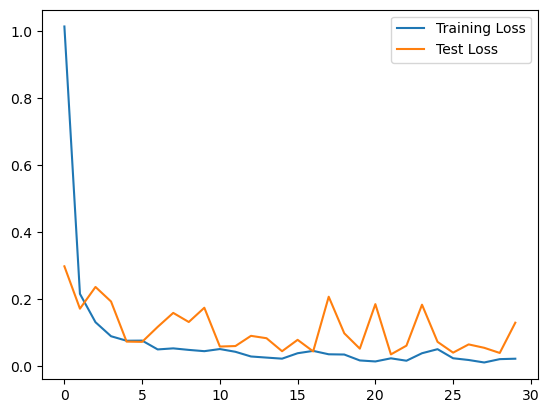

ELAPSED TIME: 3401.1s


In [37]:
model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#Scheduler that will modify the learning ratio dinamically according to the test loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_train, loss_test, acc_test, elapsed, pred = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer,
                                                      scheduler,
                                                      train_dataloader, 
                                                      test_dataloader)




The final accuracy of the model is 96.6%, with an average loss of the test slightly higher than the average loss of teh train, which indicates a bit of overfitting in the model. 

To avoid this overfitting, we would have to add more regularization parameters, such as adding more Dropouts on the model or adding an early stopper. If we had a better cpu, we could add this parameters and train the model, but with the current cpu it would be a waste of time.

Let's have some insight on how our model is.

In [38]:
calculate_parameters_and_flops(model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
CNN | 3.98 Params(M) | 22.747 FLOPs(M)


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


(22747114.0, 3978783.0)

Our model has 4 million weights, performing 22.7 milion FLOPs, quite a decent amount.

### Metric analysis

Time to see how our model perform with other metrics. Firstly we will check the confusion matrix, to see where the errors are.

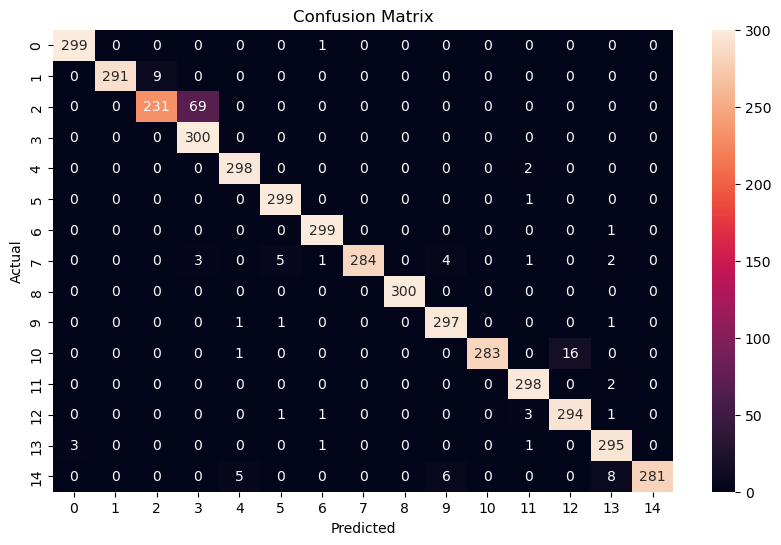

['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '万', '亿']

In [39]:
cm = metrics.confusion_matrix(target_test-1,pred)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
[x for _,x in sorted(zip(dataset_raw['code'].unique(),dataset_raw['character'].unique()))]


There is basically no error on most of the classes, except for the third one that has many of the images classified as the fourth class (two straight lines are somehow seen as three straight lines) and there's also some misclassifying in the 11th class, being seen as the 13th class (we can see they are quite similar).

Now let's evaluate the precision, recall and f-1 score.

In [40]:
print(metrics.classification_report(target_test-1,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       300
           1       1.00      0.97      0.98       300
           2       0.96      0.77      0.86       300
           3       0.81      1.00      0.89       300
           4       0.98      0.99      0.99       300
           5       0.98      1.00      0.99       300
           6       0.99      1.00      0.99       300
           7       1.00      0.95      0.97       300
           8       1.00      1.00      1.00       300
           9       0.97      0.99      0.98       300
          10       1.00      0.94      0.97       300
          11       0.97      0.99      0.98       300
          12       0.95      0.98      0.96       300
          13       0.95      0.98      0.97       300
          14       1.00      0.94      0.97       300

    accuracy                           0.97      4500
   macro avg       0.97      0.97      0.97      4500
weighted avg       0.97   

Except for the third class and the fourth, all classes have a pretty good f1-score. We can see that the precission of the fourth class is the lowest, while the recall of the third is the lowest, which makes sense after what we saw on the confusion matrix. 

### Data Augmentation

The model is already very good, and we may achieve better accuracy with more epochs (the computer would no like that, though), but a better way to improve the model is to have more data available. In order to get more data (more images), we can apply data augmentation on our images from the train set, generating new images (rotated, translated, brightness, etc) that would help our model classify our images. 

While CNN have the property of spatial invariance (recognise the image in any position), we have to be careful because flipping or rotating a chinese character could made this one become a completely different character (for example in our case, the carachter with code 9 flipped could be identified easily as the one with code 3 if the handwritting is not good), so we won't flip images and the rotations applied won't be big.

With all this in consideration, now we can proceed importing the albumentations packages, that let's us perform this transformations without problem.

In [41]:
import albumentations as A

Let's set up the transformations that our images will perform. We will create two new images for each sample in the train set, and those will suffer some transformations according to some probabilities for each transformation. For this model only Geometric Transformations are suitable.

In [42]:
def image_augmentation_transformation(image):

    transform2 = A.Compose([
        A.OneOf([
                A.Affine(scale=np.random.uniform(0.5,1.5), p=0.5),
        A.Affine(translate_percent=None, translate_px=np.random.randint(-8,8),p=0.5)
        ], p=0.9),
        A.Affine(rotate=np.random.randint(-45,45),p=0.8)

    ])
    transformed = transform2(image=image)
    return transformed["image"]

In [43]:
#we create a list to add the transformed images and we modify our targets for our trains
#so every new image has its corresponding label
images_aug_train = []
target_aug_train=pd.Series(target_train.tolist()*3)


In [44]:
#double for loop to create the new images in the same order as the labels
for z in range(2):
    for img in images_train:
        trans_img = image_augmentation_transformation(img)
        images_aug_train.append(trans_img)

images_aug_train= np.array(images_aug_train)
images_aug_train = np.concatenate((images_train,images_aug_train), axis=0)

Now that we have augmented our dataset, we can proceed as before.

In [45]:
epochs = 20 #we reduce epochs, it would take too much time

We have to create a new dataloader object with the new train dataset

In [46]:
train_ds_aug = CustomImageDataset(images_aug_train, target_aug_train, transform)
train_dataloader_aug = torch.utils.data.DataLoader(train_ds_aug, **train_kwargs)


Now we train and test the model as before

EPOCH 1


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.2165, Accuracy: 4174/4500 (92.76%)

EPOCH 2


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 4402/4500 (97.82%)

EPOCH 3


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 4400/4500 (97.78%)

EPOCH 4


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 4424/4500 (98.31%)

EPOCH 5


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 4438/4500 (98.62%)

EPOCH 6


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 4388/4500 (97.51%)

EPOCH 7


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 4431/4500 (98.47%)

EPOCH 8


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1993, Accuracy: 4241/4500 (94.24%)

EPOCH 9


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 4427/4500 (98.38%)

EPOCH 10


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.1150, Accuracy: 4320/4500 (96.00%)

EPOCH 11


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 4425/4500 (98.33%)

EPOCH 12


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 4432/4500 (98.49%)

EPOCH 13


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 4450/4500 (98.89%)

EPOCH 14


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 4455/4500 (99.00%)

EPOCH 15


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 4477/4500 (99.49%)

EPOCH 16


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 4445/4500 (98.78%)

EPOCH 17


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 4426/4500 (98.36%)

EPOCH 18


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 4476/4500 (99.47%)

EPOCH 19


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0154, Accuracy: 4475/4500 (99.44%)

EPOCH 20


  0%|          | 0/315 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 4464/4500 (99.20%)



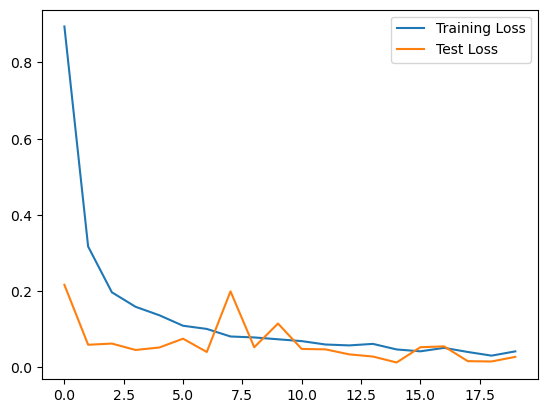

ELAPSED TIME: 7032.3s


In [49]:
model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_train, loss_test, acc_test, elapsed, pred = experiment(model, 
                                                      device, 
                                                      loss, 
                                                      optimizer,
                                                      scheduler,
                                                      train_dataloader_aug, 
                                                      test_dataloader)



We can see how much the model has improved, and that it stills suffer from overfitting, although not as much as before (training loss is higher thant test loss, but this last should be decreasing for all epochs and it is not the case). We could add a checkpointer, to use the model with the best accuracy, but we will stay with the model of the last epoch.

In terms of accuracy, it achieves a 99.2%, and it will be interesting to see where the errors are.

### Metric Analysis

Like before, we start with analysing a confusion matrix

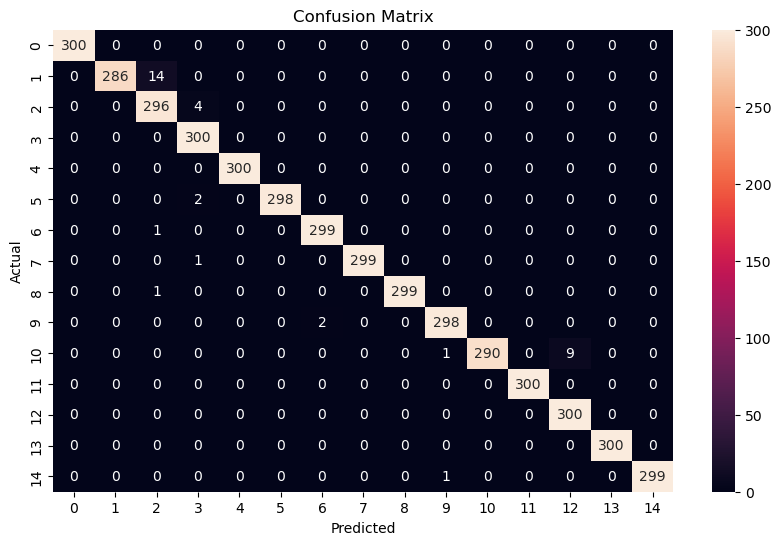

['零', '一', '二', '三', '四', '五', '六', '七', '八', '九', '十', '百', '千', '万', '亿']


In [82]:
cm = metrics.confusion_matrix(target_test-1,pred)
plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
characters = [x for _,x in sorted(zip(dataset_raw['code'].unique(),dataset_raw['character'].unique()))]
print(characters)


We can see that most of the classes are perfectly classified, except for a couple. Now the main error is found at the second class, where some of the images are predicted as the third (one straight line seen as two), and there is also some mislabelling in the eleventh class. In general, those are very good results and the error could be solved most likely.

Now let's see how the classes perfom at the different metrics.

In [51]:
print(metrics.classification_report(target_test-1,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      0.95      0.98       300
           2       0.95      0.99      0.97       300
           3       0.98      1.00      0.99       300
           4       1.00      1.00      1.00       300
           5       1.00      0.99      1.00       300
           6       0.99      1.00      1.00       300
           7       1.00      1.00      1.00       300
           8       1.00      1.00      1.00       300
           9       0.99      0.99      0.99       300
          10       1.00      0.97      0.98       300
          11       1.00      1.00      1.00       300
          12       0.97      1.00      0.99       300
          13       1.00      1.00      1.00       300
          14       1.00      1.00      1.00       300

    accuracy                           0.99      4500
   macro avg       0.99      0.99      0.99      4500
weighted avg       0.99   

As expected, the second class has the worse recall and the third the worse precission, and most of the classes are perfectly classified (1 as f1-score).

#### Errors

The model perfroms incredible, but can be improved. In order to do that, we have to take a look at mislabelled images

(0)Wrong label: 七 Correct label: 五
(1)Wrong label: 九 Correct label: 八
(2)Wrong label: 二 Correct label: 一
(3)Wrong label: 二 Correct label: 一


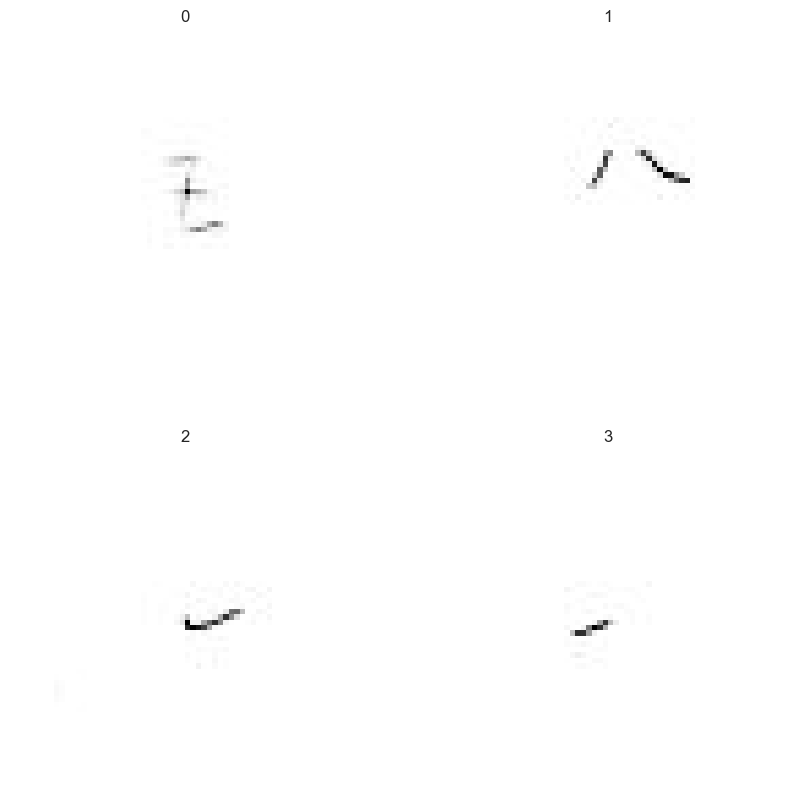

In [153]:
preds_model1 = pred
preds_mod = []

for i in preds_model1:
    preds_mod.append(i[0]+1)

y_true = target_test.tolist()
#We check which images are wrongly labelled
wrong_labels = np.argwhere(np.array(y_true)!=np.array(preds_mod)) 

n_errors = len(wrong_labels)
#Now we plot randomly 4 of the errors
index = np.random.randint(n_errors, size=4)
f, ax = plt.subplots(2,2, figsize=(10,10))

for i,num in enumerate(index):
    img_data = skimage.io.imread(IMAGE_PATH + image_files[num])
    ax[i//2, i%2].set_title(i)
    ax[i//2, i%2].imshow(images_test[wrong_labels[num][0]])
    ax[i//2, i%2].axis('off')
    print("("+str(i)+")Wrong label:",characters[preds_mod[wrong_labels[num][0]]-1],preds_mod[wrong_labels[num][0]-1],"Correct label:",characters[y_true[wrong_labels[num][0]]-1])
plt.show()    
    

## Future work

In order to improve our model we have different options:

1. Increasing number of epochs

2. Doing a Convolutional XGBoost (and ensemble of a CNN and XGBoost Classifier)

3. Doing more data augmentation

4. Adding a checkpointer that retrieve the model with the best accuracy (we would have to add then a validation set)

5. Trying with different models (for example Residual Networks)

6. Doing Hyperparameter Tunning of the parameters of the optimizer, scheduler, ...

To avoid the present overfitting, we can do the following:

1. Adding dropouts on the model

2. Adding weight decay on the optimizer

3. Early stopping when the test loss stops improving (important the value of the patience).

Due to the time given, and the performance of the computer, we can not test all this.

Finally, let's make a brief summary of all the models and their results.

## Benchmark & Comparison of metrics

| Model | Time Elapsed (s) | Mean Test Accuracy (%)  |
| ----------------|---------------|-----------------|
| KNN | 338 | 41 |
| RandomForestClassifier | 45 | 55 |
| XGBoost | 573 | 43 |
| RandomForestClassifier (Hyperparamet Search) | 173 | 62 |
| CNN | 3400 | 96.6 |
| CNN Data Augmentation | 7032 | 99.2 |

Let's look at the metrics for some of the classes.

Class 3:

| Metric | RandomForest | CNN | CNN Data Augmentation |
| ----------------|---------------|-----------------|-----|
| Precission | 0.65 | 0.96 | 1 |
| Recall | 0.73 | 0.77 | 0.99|
| F1-Score | 0.69 | 0.86 | 0.97|


Class 11:

| Metric | RandomForest | CNN | CNN Data Augmentation | 
| ----------------|---------------|-----------------|-----|
| Precission | 0.63 | 1 | 1 |
| Recall | 0.69 | 0.94 | 0.97|
| F1-Score | 0.66 | 0.97 | 0.98|


## Conclusions

We have been able to see that CNN are great models for image classification, and that Data Augmentation is a great technique to improve models.

Furthermore, we have seen that there are cases where Artificial Neural Networks models will outperform considerably conventional Machine Learning models (such as KNN and Random Forest).

Talking about the dataset, it is not one of the most difficult to analise, as we have seen. There are no flaws on the dataset (no NaNs, etc) and most of the images are quite clear, there is barely noise, being this the reason of such high accuracy score.

I firmly believe that is a good alternative to the classis MNIST to practice with CNN, given that chinese characters are very different to conventional numbers, and it can help to understand how CNN perform.

With all this said, I think that perfect accuracy can be achieved in this dataset, giving the necessary thought to the model and the differents techniques applied.